In [82]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.download('BTC-USD')
btc_df = btc_df.reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Adj Close', 'Volume', 'Unnamed: 0', "wallets", "address", "mined"])

[*********************100%***********************]  1 of 1 completed


In [83]:
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
df = df.dropna()


In [84]:
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3

In [85]:
df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")

In [86]:
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = df['price-meanavge']/(df['price'] + df['meanavge'])

In [87]:
df.describe()

,price,meanavge,meanvalue,price-meanavge,move%
count,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000
mean,9309.407579,8853.515311,455.892268,455.892268,0.044572
std,14913.290058,14035.823551,5034.993658,5034.993658,0.173339
min,2.000000,4.964000,-19157.461556,-19157.461556,-0.659858
25%,252.375000,272.770000,-117.624750,-117.624750,-0.077142
50%,1174.550000,893.913472,17.727028,17.727028,0.047845
75%,9905.225000,8683.591986,449.507750,449.507750,0.145326
max,67527.900000,52102.493056,31522.240056,31522.240056,0.706969


In [88]:
bins = [-0.43, -0.1, 0, 0.1, 0.43]
group_names = ["Severely Oversold","Oversold", "Neutral","Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)
df

,date,price,meanavge,meanvalue,status,price-meanavge,move%,Valuation
299,2011-07-21,13.600000,8.704611,4.895389,1,4.895389,0.219479,Overbought
300,2011-07-22,13.700000,8.762722,4.937278,1,4.937278,0.219799,Overbought
301,2011-07-23,13.700000,8.796167,4.903833,1,4.903833,0.217985,Overbought
302,2011-07-24,14.000000,8.801778,5.198222,1,5.198222,0.227974,Overbought
303,2011-07-25,14.100000,8.823000,5.277000,1,5.277000,0.230205,Overbought
...,...,...,...,...,...,...,...,...
4428,2022-12-07,16848.126953,22212.162412,-5364.035459,0,-5364.035459,-0.137327,Severely Oversold
4429,2022-12-08,17233.474609,22149.854450,-4916.379840,0,-4916.379840,-0.124834,Severely Oversold
4430,2022-12-09,17133.152344,22089.331388,-4956.179045,0,-4956.179045,-0.126361,Severely Oversold
4431,2022-12-10,17128.724609,22027.202954,-4898.478345,0,-4898.478345,-0.125102,Severely Oversold


In [89]:
df['Valuation'].value_counts()

Overbought           1410
Neutral               991
Oversold              851
Severely Oversold     780
Name: Valuation, dtype: int64

12:36:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing


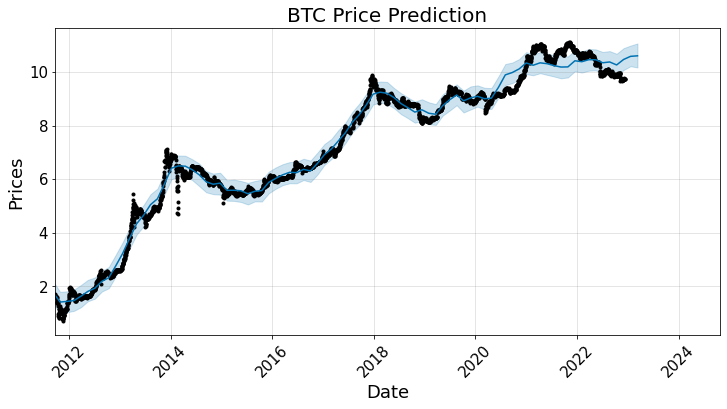

In [90]:
## Combine with Prophet
from datetime import timedelta, date
from prophet import Prophet
df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=90)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2011-09-25', '2024-10-24'])) 
plt.show();

In [91]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","orange","yellow","green"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.show()
fig.layout.template = 'seaborn'
fig.write_html('../static/combo.html')

In [92]:
df['status'] = df['status'].replace({'0': 'Undervalue'})
df['status'] = df['status'].replace({'1': 'Overvalued'})

In [93]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Moving Average Status')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(
	updatemenus=[
		dict(
			active=0,
			buttons=list([
				dict(label="Both",
					method="update",
					args=[{"visible": [True, True, True]},
						{"title": "Both"}]),
				dict(label="Overvalue",
					method="update",
					args=[{"visible": [True, False, False]},
						{"title": "Overvalue",
							}]),
				
				dict(label="Undervalue",
					method="update",
					args=[{"visible": [False, True, True]},
						{"title": "Undervalue",
							}]),
				
			]),
		)
	])
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus.html')

In [94]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="meanavge", trendline="expanding", trendline_options=dict(function="max"),
                 title="MeanAvg")
fig.add_trace(go.Scatter(name="Middle", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
fig.add_trace(go.Scatter(name="Lower", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
fig.add_trace(go.Scatter(name="Upper", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Mean Average and Prophet Prophet Model')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.show()
fig.layout.template = 'seaborn'
fig.write_html('../static/MAandPred.html')

12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1] done processing


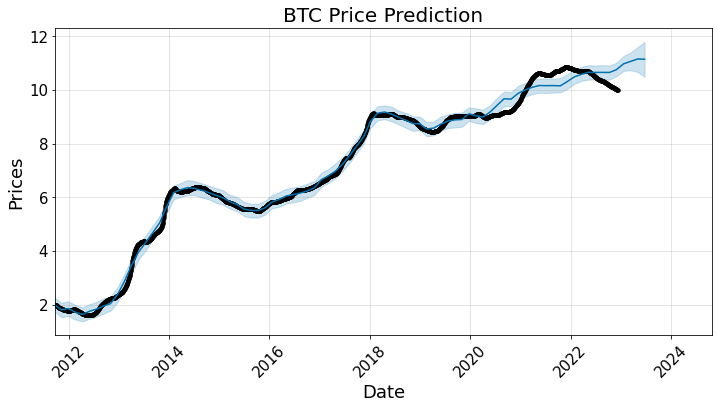

In [95]:
## Combine with Prophet
from prophet import Prophet
df['meanavgeL'] = np.log(df['meanavge'])

df_train = df[['date', 'meanavgeL']]
df_train = df_train.rename(columns = {"date":"ds", "meanavgeL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = "2023-06-24"
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2011-09-25', '2024-10-24'])) 
plt.show();

In [96]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="meanavge", trendline="expanding", trendline_options=dict(function="max"),
                 title="MeanAvg")
fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Moving Average and Prophet')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-01', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-05-01', line_width=3, line_dash="dash", line_color="green")	
fig.show()
fig.layout.template = 'seaborn'
fig.write_html('../static/MAandPred2.html')